In [1]:
#@title Installs

# !pip install pydot --quiet
# !pip install gensim --quiet
# !pip install tensorflow-datasets --quiet
# !pip install -U tensorflow-text --quiet
!pip install transformers --quiet

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# !source /content/drive/MyDrive/vir_env/bin/activate;

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
# import tensorflow_datasets as tfds
# # import tensorflow_text as tf_text

from keras.callbacks import EarlyStopping
my_callbacks = [EarlyStopping(patience=2, monitor="accuracy")]

from sklearn.metrics import classification_report

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re
import pandas as pd

import pickle

In [4]:
cd '/content/drive/MyDrive/Berkeley/w266/'

/content/drive/MyDrive/Berkeley/w266


In [5]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 20 15:04:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 20 15:04:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
file_path = 'data/'
train_df = pd.read_csv(file_path+'train_df_review.csv')
test_df = pd.read_csv(file_path+'test_df_review.csv')
val_df = pd.read_csv(file_path+'val_df_review.csv')

In [8]:
train_df.head()

,claim,id,rating,original_rating,review,review_claim,new_rating,question
0,OpIndia claimed Greta Thunberg's real name is ...,1,0,false,['Link profile Link canonical Skip to co...,OpIndia claimed Greta Thunberg's real name is ...,false,"Is the claim ""OpIndia claimed Greta Thunberg's..."
1,"“38,000 prisoners were released from federal p...",2,1,misleading,['Link profile Link canonical Link shor...,"“38,000 prisoners were released from federal p...",misleading,"Is the claim ""“38,000 prisoners were released ..."
2,Says Wisconsin ‘could compel’ Foxconn to insta...,3,1,barely-true,['The Poynter Institute Menu Donate ...,Says Wisconsin ‘could compel’ Foxconn to insta...,misleading,"Is the claim ""Says Wisconsin ‘could compel’ Fo..."
3,A 4-year-old boy was accused of hacking the FB...,4,0,false,['Link canonical Link shortlink Snopes c...,A 4-year-old boy was accused of hacking the FB...,false,"Is the claim ""A 4-year-old boy was accused of ..."
4,Whistleblower accusing Philippine VP of fraud ...,5,1,misleading,['Link profile Link canonical Link shor...,Whistleblower accusing Philippine VP of fraud ...,misleading,"Is the claim ""Whistleblower accusing Philippin..."


In [4]:
# 6-window plot of loss and accuracy for three models, for comparison

def make_plot(axs,
              model_history1,
              model_history2,
              model_history3,
              model_1_name='model 1',
              model_2_name='model 2',
              model_3_name='model 3',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2, model_history3]):
            model_name = [model_1_name, model_2_name, model_3_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)


# 4-window plot of loss and accuracy for two models, for comparison

def make_2plots(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2'
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)




In [10]:
from transformers import BertTokenizer, TFBertModel

from transformers import logging
logging.set_verbosity_error()

**Claim + Review**

change max Legnth to 700

In [11]:
checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

field = 'claim'


dummy_train_y = np.array(pd.get_dummies(train_df['new_rating']))
dummy_valid_y = np.array(pd.get_dummies(val_df['new_rating']))
dummy_test_y = np.array(pd.get_dummies(test_df['new_rating']))


train_examples = train_df[field].values.tolist()
train_examples = tf.convert_to_tensor(train_examples)
train_labels = np.array(train_df['rating'].values.tolist())


test_examples = test_df[field].values.tolist()
test_examples = tf.convert_to_tensor(test_examples)
test_labels = np.array(test_df['rating'].values.tolist())



val_examples = val_df[field].values.tolist()
val_examples = tf.convert_to_tensor(val_examples)
val_labels = np.array(val_df['rating'].values.tolist())

MAX_SEQUENCE_LENGTH = 300                 # set max_length of the input sequence

all_train_examples = [x.decode('utf-8') for x in train_examples.numpy()]
all_test_examples = [x.decode('utf-8') for x in val_examples.numpy()]

x_train = bert_tokenizer(all_train_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_labels

x_test = bert_tokenizer(all_test_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = val_labels

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

**1 CNN layer**

*Review*

In [12]:


def create_bert_cnn_classification_model(bert_model,
                                         num_train_layers=12,
                                         hidden_size=200,
                                         dropout=0.3,
                                         cnn_filters=128,
                                         cnn_kernel_size=3,
                                         learning_rate=0.00005):
    if num_train_layers == 0:
        bert_model.trainable = False
    elif num_train_layers == 12:
        bert_model.trainable = True
    else:
        retrain_layers = ['_' + str(11 - retrain_layer_number) for retrain_layer_number in range(num_train_layers)]
        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]

    # Adding a Convolutional Neural Network (CNN) layer
    cnn_layer = tf.keras.layers.Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, activation='relu')(bert_out[0])

    # Global Max Pooling to reduce dimensionality
    cnn_max_pooling = tf.keras.layers.GlobalMaxPooling1D()(cnn_layer)

    # Concatenate BERT pooler output with CNN max pooling
    concatenated_features = tf.keras.layers.Concatenate()([pooler_token, cnn_max_pooling])

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(concatenated_features)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(3, activation='softmax', name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.categorical_crossentropy,
                                 metrics=['accuracy'])

    return classification_model


In [18]:
bert_model = TFBertModel.from_pretrained(checkpoint)
bert_classification_model_claim = create_bert_cnn_classification_model(bert_model, num_train_layers=12)
bert_classification_model_claim.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 300)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 300)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 300)]                0         []                            
 tLayer)                                                                                    

In [20]:
bert_classification_model_claim_history = bert_classification_model_claim.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    dummy_train_y,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], dummy_valid_y),
    batch_size=16,
    epochs=4, callbacks=my_callbacks)

Epoch 1/4
1686/1686 [==============================] - 449s 247ms/step - loss: 0.8653 - accuracy: 0.6002 - val_loss: 0.8503 - val_accuracy: 0.5973
Epoch 2/4
1686/1686 [==============================] - 412s 244ms/step - loss: 0.7944 - accuracy: 0.6418 - val_loss: 0.8436 - val_accuracy: 0.6168
Epoch 3/4
1686/1686 [==============================] - 412s 244ms/step - loss: 0.6839 - accuracy: 0.6989 - val_loss: 0.9300 - val_accuracy: 0.6005
Epoch 4/4
1686/1686 [==============================] - 412s 244ms/step - loss: 0.5030 - accuracy: 0.7986 - val_loss: 1.0574 - val_accuracy: 0.5712


In [21]:
bert_claim_score = bert_classification_model_claim.evaluate([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],dummy_train_y)
print("%s: %.2f%%" % (bert_classification_model_claim.metrics_names[1], bert_claim_score[1]*100))

843/843 [==============================] - 134s 159ms/step - loss: 0.2463 - accuracy: 0.9311
accuracy: 93.11%


In [22]:
# from sklearn.metrics import classification_report

all_test_t_examples = [x.decode('utf-8') for x in test_examples.numpy()]

x_test = bert_tokenizer(all_test_t_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

y_pred = bert_classification_model_claim.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_labels, y_pred_bool))

53/53 [==============================] - 19s 289ms/step
              precision    recall  f1-score   support

           0       0.68      0.59      0.63      1461
           1       0.60      0.63      0.62      1545
           2       0.31      0.40      0.34       367

    accuracy                           0.59      3373
   macro avg       0.53      0.54      0.53      3373
weighted avg       0.60      0.59      0.59      3373



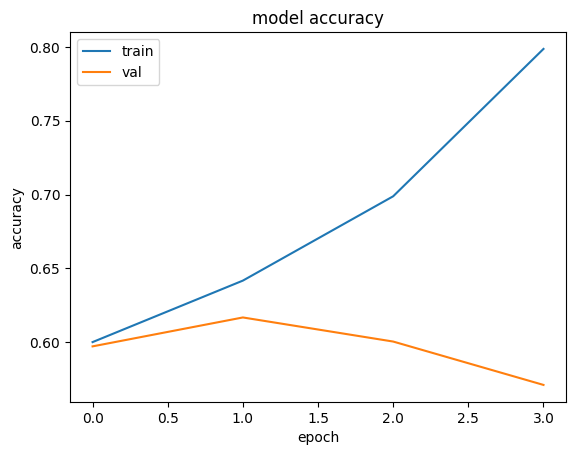

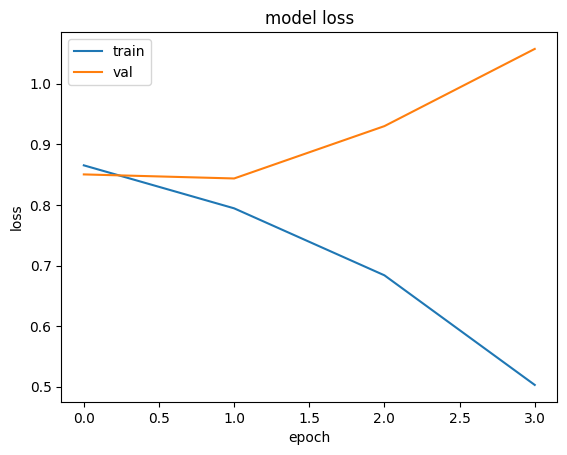

In [32]:


# summarize history for accuracy
plt.plot(bert_classification_model_claim_history.history['accuracy'])
plt.plot(bert_classification_model_claim_history.history['val_accuracy'])
plt.title('model accuracy for claim')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(bert_classification_model_claim_history.history['loss'])
plt.plot(bert_classification_model_claim_history.history['val_loss'])
plt.title('model loss for claim')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [33]:
claim_history = bert_classification_model_claim_history.history
print(claim_history)
with open("/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_claim_final.pkl", "wb") as f:
    pickle.dump(claim_history, f)

bert_classification_model_claim.save('/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_claim.h5')
bert_classification_model_claim.save("/content/drive/MyDrive/Berkeley/w266/final_project/model/my_model_claim")

{'loss': [0.8653023838996887, 0.7943713068962097, 0.6838514804840088, 0.5030102133750916], 'accuracy': [0.6001631021499634, 0.6417927145957947, 0.6988804936408997, 0.7986358404159546], 'val_loss': [0.8503395318984985, 0.8436448574066162, 0.9300262928009033, 1.0573869943618774], 'val_accuracy': [0.5972716212272644, 0.6168445944786072, 0.6005337834358215, 0.5711743831634521]}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Only Review**

Change max length to 500

In [34]:
checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

field = 'review'


dummy_train_y = np.array(pd.get_dummies(train_df['new_rating']))
dummy_valid_y = np.array(pd.get_dummies(val_df['new_rating']))
dummy_test_y = np.array(pd.get_dummies(test_df['new_rating']))


train_examples = train_df[field].values.tolist()
train_examples = tf.convert_to_tensor(train_examples)
train_labels = np.array(train_df['rating'].values.tolist())


test_examples = test_df[field].values.tolist()
test_examples = tf.convert_to_tensor(test_examples)
test_labels = np.array(test_df['rating'].values.tolist())



val_examples = val_df[field].values.tolist()
val_examples = tf.convert_to_tensor(val_examples)
val_labels = np.array(val_df['rating'].values.tolist())

MAX_SEQUENCE_LENGTH = 500                 # set max_length of the input sequence

all_train_examples = [x.decode('utf-8') for x in train_examples.numpy()]
all_test_examples = [x.decode('utf-8') for x in val_examples.numpy()]

x_train = bert_tokenizer(all_train_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_labels

x_test = bert_tokenizer(all_test_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = val_labels

In [36]:
bert_model = TFBertModel.from_pretrained(checkpoint)
bert_classification_model_review = create_bert_cnn_classification_model(bert_model, num_train_layers=12, dropout=0.5)
bert_classification_model_review.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 500)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 500)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 500)]                0         []                            
 tLayer)                                                                                    

In [37]:
bert_classification_model_review_history = bert_classification_model_review.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    dummy_train_y,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], dummy_valid_y),
    batch_size=16,
    epochs=4, callbacks=my_callbacks)

Epoch 1/4
1686/1686 [==============================] - 729s 413ms/step - loss: 0.3038 - accuracy: 0.8805 - val_loss: 0.1528 - val_accuracy: 0.9416
Epoch 2/4
1686/1686 [==============================] - 693s 411ms/step - loss: 0.1415 - accuracy: 0.9478 - val_loss: 0.1449 - val_accuracy: 0.9517
Epoch 3/4
1686/1686 [==============================] - 693s 411ms/step - loss: 0.1327 - accuracy: 0.9511 - val_loss: 0.1462 - val_accuracy: 0.9478
Epoch 4/4
1686/1686 [==============================] - 693s 411ms/step - loss: 0.1035 - accuracy: 0.9621 - val_loss: 0.1399 - val_accuracy: 0.9520


In [38]:
bert_review_score = bert_classification_model_review.evaluate([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],dummy_train_y)
print("%s: %.2f%%" % (bert_classification_model_review.metrics_names[1], bert_review_score[1]*100))
print('\n')

all_test_t_examples = [x.decode('utf-8') for x in test_examples.numpy()]

x_test = bert_tokenizer(all_test_t_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

y_pred = bert_classification_model_review.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

# run it with test data


print(classification_report(test_labels, y_pred_bool))


843/843 [==============================] - 222s 263ms/step - loss: 0.0718 - accuracy: 0.9731
accuracy: 97.31%


53/53 [==============================] - 29s 499ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1461
           1       0.93      0.96      0.95      1545
           2       1.00      0.92      0.96       367

    accuracy                           0.95      3373
   macro avg       0.96      0.94      0.95      3373
weighted avg       0.95      0.95      0.95      3373



In [39]:
review_history = bert_classification_model_review_history.history
print(review_history)
with open("/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_review_final.pkl", "wb") as f:
    pickle.dump(review_history, f)

bert_classification_model_review.save('/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_review.h5')
bert_classification_model_review.save("/content/drive/MyDrive/Berkeley/w266/final_project/model/my_model_review")

{'loss': [0.30384546518325806, 0.14149291813373566, 0.13274478912353516, 0.10353776812553406], 'accuracy': [0.8805234432220459, 0.9478054642677307, 0.9510676264762878, 0.9621144533157349], 'val_loss': [0.15276214480400085, 0.14492107927799225, 0.1462087482213974, 0.1399412453174591], 'val_accuracy': [0.941577672958374, 0.9516607522964478, 0.9478054642677307, 0.9519572854042053]}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


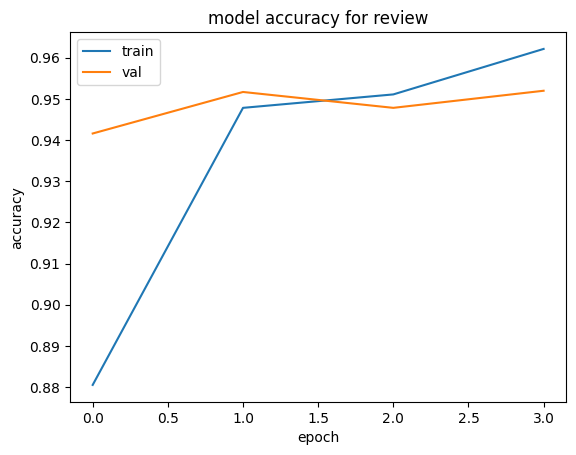

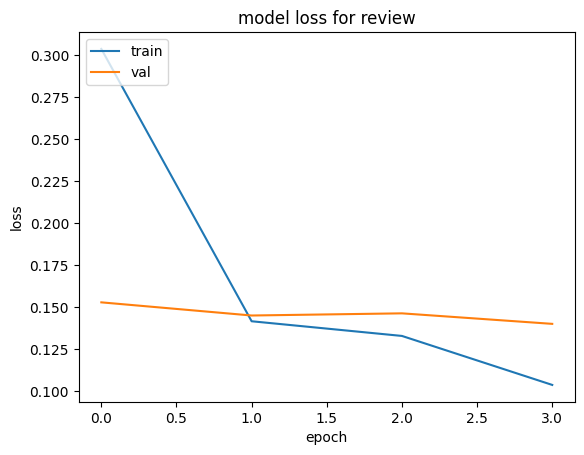

In [40]:

# summarize history for accuracy
plt.plot(bert_classification_model_review_history.history['accuracy'])
plt.plot(bert_classification_model_review_history.history['val_accuracy'])
plt.title('model accuracy for review')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(bert_classification_model_review_history.history['loss'])
plt.plot(bert_classification_model_review_history.history['val_loss'])
plt.title('model loss for review')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

** Running only for Claim**

In [43]:
checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

field = 'review_claim'


dummy_train_y = np.array(pd.get_dummies(train_df['new_rating']))
dummy_valid_y = np.array(pd.get_dummies(val_df['new_rating']))
dummy_test_y = np.array(pd.get_dummies(test_df['new_rating']))


train_examples = train_df[field].values.tolist()
train_examples = tf.convert_to_tensor(train_examples)
train_labels = np.array(train_df['rating'].values.tolist())


test_examples = test_df[field].values.tolist()
test_examples = tf.convert_to_tensor(test_examples)
test_labels = np.array(test_df['rating'].values.tolist())



val_examples = val_df[field].values.tolist()
val_examples = tf.convert_to_tensor(val_examples)
val_labels = np.array(val_df['rating'].values.tolist())

MAX_SEQUENCE_LENGTH = 800                 # set max_length of the input sequence

all_train_examples = [x.decode('utf-8') for x in train_examples.numpy()]
all_test_examples = [x.decode('utf-8') for x in val_examples.numpy()]

x_train = bert_tokenizer(all_train_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_labels

x_test = bert_tokenizer(all_test_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = val_labels

In [44]:
bert_model = TFBertModel.from_pretrained(checkpoint)
bert_classification_model_claim_review = create_bert_cnn_classification_model(bert_model, num_train_layers=12, dropout=0.5)
bert_classification_model_claim_review.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 800)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 800)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 800)]                0         []                            
 tLayer)                                                                                    

In [46]:
bert_classification_model_claim_review_history = bert_classification_model_claim_review.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    dummy_train_y,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], dummy_valid_y),
    batch_size=16,
    epochs=4, callbacks=my_callbacks)

Epoch 1/4
1686/1686 [==============================] - 1215s 721ms/step - loss: 0.2772 - accuracy: 0.8927 - val_loss: 0.1703 - val_accuracy: 0.9410
Epoch 2/4
1686/1686 [==============================] - 1211s 719ms/step - loss: 0.1326 - accuracy: 0.9502 - val_loss: 0.1262 - val_accuracy: 0.9517
Epoch 3/4
1686/1686 [==============================] - 1211s 718ms/step - loss: 0.1190 - accuracy: 0.9558 - val_loss: 0.1298 - val_accuracy: 0.9490
Epoch 4/4
1686/1686 [==============================] - 1211s 718ms/step - loss: 0.1006 - accuracy: 0.9652 - val_loss: 0.1426 - val_accuracy: 0.9463


In [47]:
bert_claim_review_score = bert_classification_model_claim_review.evaluate([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],dummy_train_y)
print("%s: %.2f%%" % (bert_classification_model_claim_review.metrics_names[1], bert_claim_review_score[1]*100))
print('\n')

all_test_t_examples = [x.decode('utf-8') for x in test_examples.numpy()]

x_test = bert_tokenizer(all_test_t_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

y_pred = bert_classification_model_claim_review.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

# run it with test data


print(classification_report(test_labels, y_pred_bool))


843/843 [==============================] - 383s 454ms/step - loss: 0.0784 - accuracy: 0.9723
accuracy: 97.23%


53/53 [==============================] - 49s 872ms/step
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1461
           1       0.91      0.97      0.94      1545
           2       1.00      0.92      0.96       367

    accuracy                           0.94      3373
   macro avg       0.96      0.94      0.95      3373
weighted avg       0.95      0.94      0.94      3373



In [48]:
claim_review_history = bert_classification_model_claim_review_history.history
print(claim_review_history)
with open("/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_claim_review_final.pkl", "wb") as f:
    pickle.dump(claim_review_history, f)

bert_classification_model_claim_review.save('/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_claim_review.h5')
bert_classification_model_claim_review.save("/content/drive/MyDrive/Berkeley/w266/final_project/model/my_model_claim_review")

{'loss': [0.2771727442741394, 0.132583349943161, 0.11902041733264923, 0.10055048018693924], 'accuracy': [0.8927194476127625, 0.9501779079437256, 0.9558496475219727, 0.9651913046836853], 'val_loss': [0.17027147114276886, 0.1262093335390091, 0.12980031967163086, 0.14259298145771027], 'val_accuracy': [0.9409846067428589, 0.9516607522964478, 0.9489917159080505, 0.9463226795196533]}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


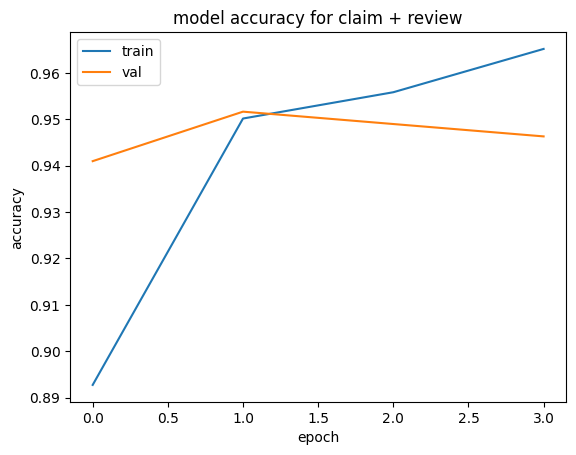

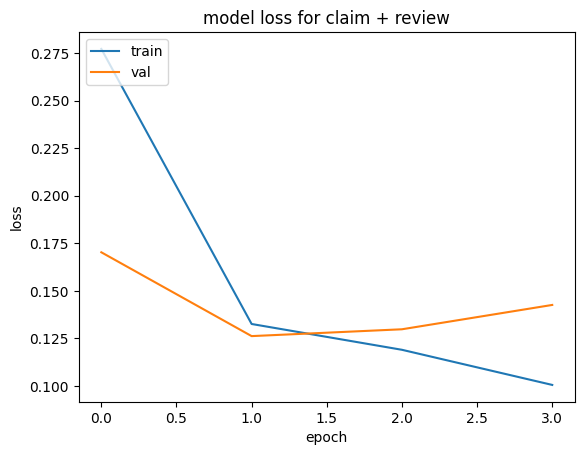

In [49]:

# summarize history for accuracy
plt.plot(bert_classification_model_claim_review_history.history['accuracy'])
plt.plot(bert_classification_model_claim_review_history.history['val_accuracy'])
plt.title('model accuracy for claim + review')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(bert_classification_model_claim_review_history.history['loss'])
plt.plot(bert_classification_model_claim_review_history.history['val_loss'])
plt.title('model loss for claim + review')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

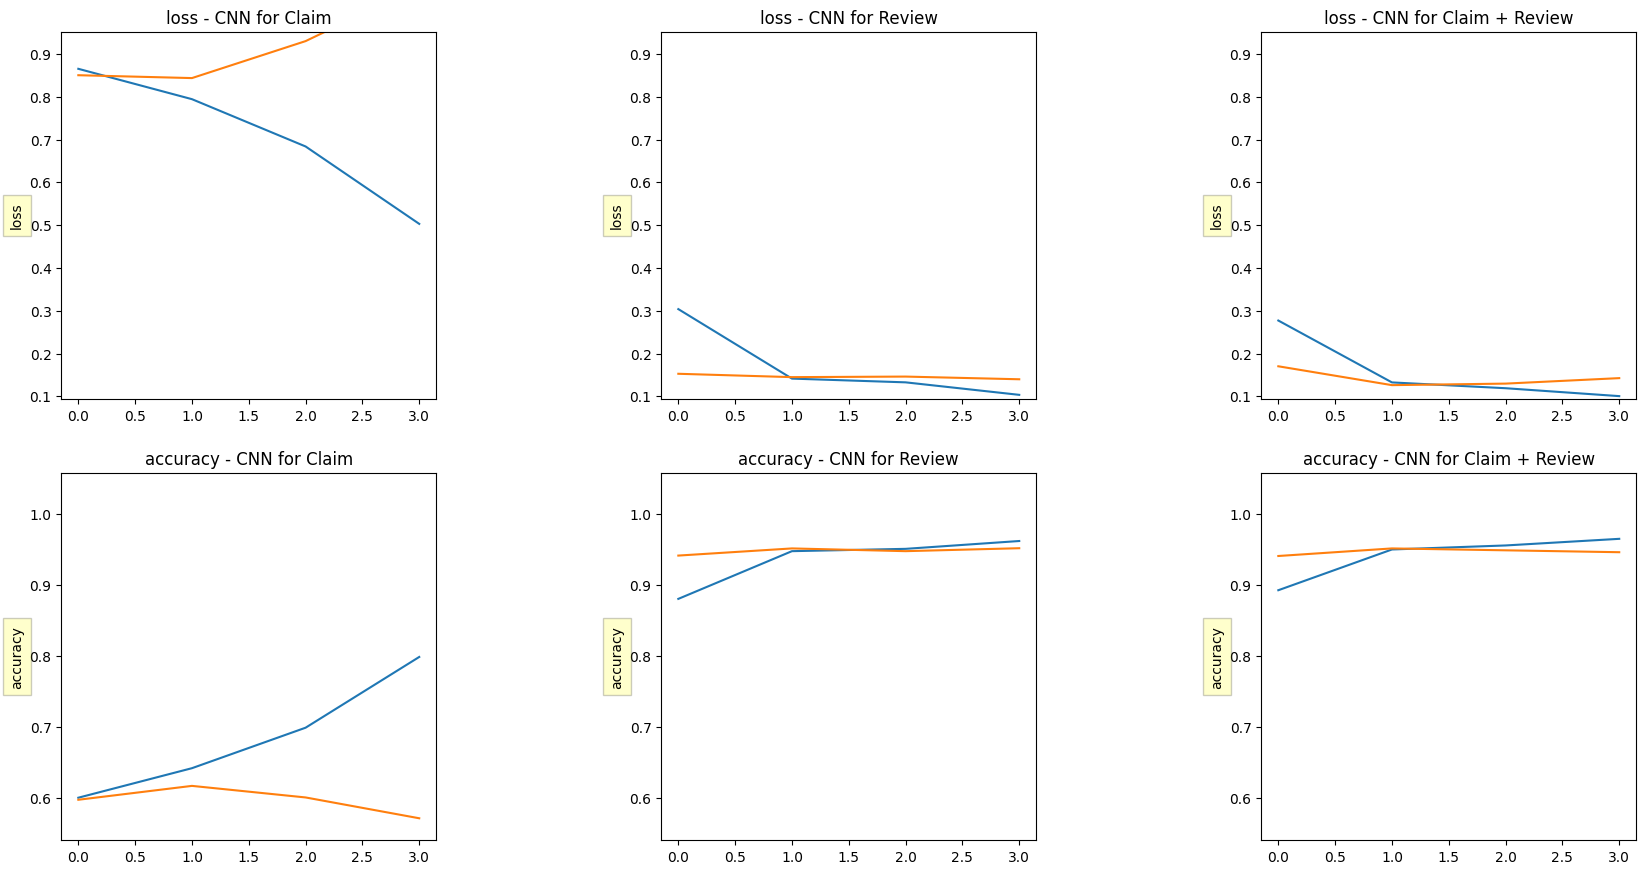

In [5]:
from pickle import load
from matplotlib.pylab import plt
import numpy as np

# Load the training and validation loss dictionaries
bert_classification_model_claim_history = load(open("/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_claim_final.pkl", "rb"))
bert_classification_model_review_history =  load(open("/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_review_final.pkl", "rb"))
bert_classification_model_claim_review_history =  load(open("/content/drive/MyDrive/Berkeley/w266/final_project/model/model_bert_cnn_claim_review_final.pkl", "rb"))


def make_plots(axs,
              model_history1,
              model_history2,
              model_history3,
              model_1_name='model 1',
              model_2_name='model 2',
              model_3_name='model 3',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1[metric])
        y_lim_lower2 = np.min(model_history2[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1[metric])
        y_lim_upper2 = np.max(model_history2[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2, model_history3]):
            model_name = [model_1_name, model_2_name, model_3_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history[metric])
            ax1.plot(model_history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

fig, axs = plt.subplots(2, 3)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plots(axs,
          bert_classification_model_claim_history,
          bert_classification_model_review_history,
          bert_classification_model_claim_review_history,
          model_1_name='CNN for Claim',
          model_2_name='CNN for Review',
          model_3_name='CNN for Claim + Review')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(22.5, 10.5)
plt.show()

All three models comparison